<a href="https://colab.research.google.com/github/dannynacker/octAVEs/blob/main/octAVEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== octAVEs: Optimized Chronometric Transposition for AudioVisual Entrainment Systems ===
Enter the path to your audio file: /content/aaa_journey_1.mp3
Enter number of channels to extract (1, 2, 3, or 4): 4
Choose transposition direction: (0) Unison, (1) Up, (2) Down
Enter your choice: 2
Interval choices:
(0) Unison
(1) Minor Second
(2) Major Second
(3) Minor Third
(4) Major Third
(5) Perfect Fourth
(6) Tritone
(7) Perfect Fifth
(8) Minor Sixth
(9) Major Sixth
(10) Minor Seventh
(11) Major Seventh
(12) Octave
Choose interval (0-12): 4
Using transposition: MajorThird Down
Invert duty cycle? (y/n): n
Enter channel mapping mode: (1) 1 channel to all 4, (2) 2 channels, (4) All 4 channels: 4
Select device output:
 (1) SCCS (CSV output for MATLAB device)
 (2) RX1 (STP .txt file output)
Enter 1 or 2: 2
Enter desired output file name (without extension): test
Extracting spectral channels from audio...
Original high-resolution CSV 'test_original.csv' created.
Apply dwell time grouping manually?

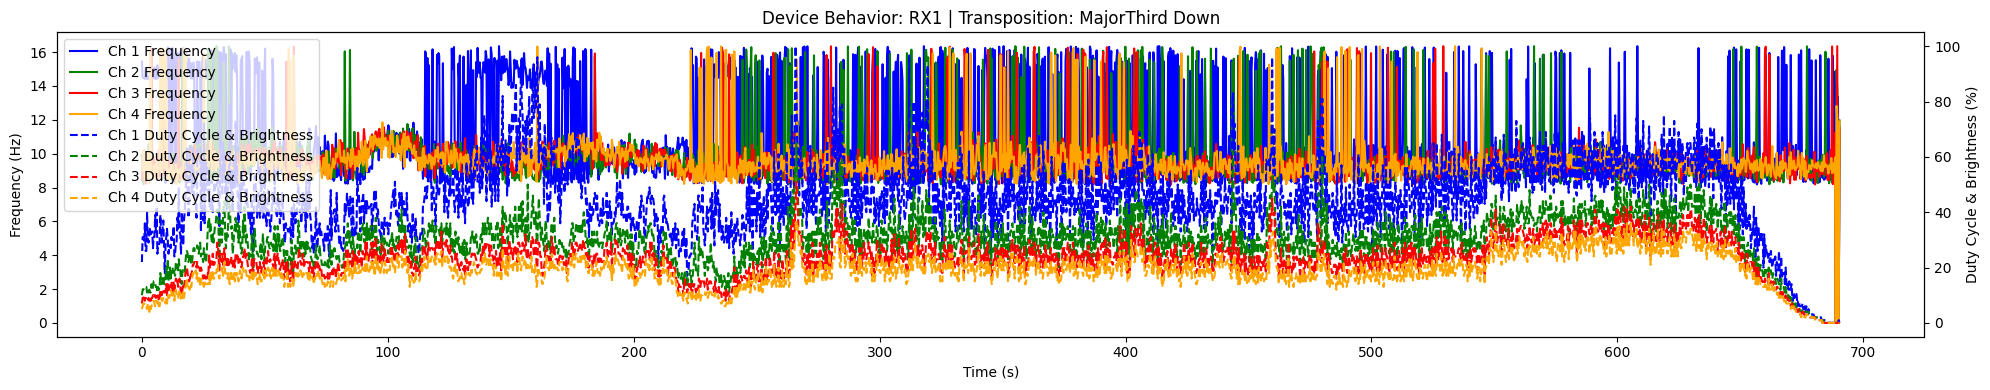

In [13]:
import numpy as np
import pandas as pd
import librosa
from scipy.signal import find_peaks
import math
import os
import matplotlib.pyplot as plt

# ----------------------------
# Helper functions for input
# ----------------------------
def get_valid_int(prompt, valid_options):
    while True:
        try:
            val = int(input(prompt).strip())
            if val in valid_options:
                return val
            else:
                print("Invalid input. Please try again.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

def get_valid_yesno(prompt):
    while True:
        ans = input(prompt).strip().lower()
        if ans in ['y', 'n']:
            return ans
        else:
            print("Invalid input. Please enter 'y' or 'n'.")

def get_valid_float_or_min(prompt):
    while True:
        ans = input(prompt).strip().lower()
        if ans == "min":
            return "min"
        try:
            val = float(ans)
            return val
        except ValueError:
            print("Invalid input. Please enter a valid number or 'min'.")

# ----------------------------
# 1) MUSICAL MAPPINGS & HELPER FUNCTIONS
# ----------------------------
intervals = {
    'Unison': 0,
    'Minor Second': 1,
    'Major Second': 2,
    'Minor Third': 3,
    'Major Third': 4,
    'Perfect Fourth': 5,
    'Tritone': 6,
    'Perfect Fifth': 7,
    'Minor Sixth': 8,
    'Major Sixth': 9,
    'Minor Seventh': 10,
    'Major Seventh': 11,
    'Octave': 12
}

note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
extended_frequencies = [
    0.51, 0.54, 0.58, 0.61, 0.65, 0.69, 0.73, 0.77, 0.82, 0.87, 0.92, 0.98,
    1.03, 1.09, 1.16, 1.22, 1.30, 1.38, 1.46, 1.54, 1.63, 1.73, 1.84, 1.95,
    2.06, 2.18, 2.31, 2.45, 2.60, 2.75, 2.92, 3.09, 3.27, 3.46, 3.67, 3.88,
    4.12, 4.36, 4.61, 4.88, 5.16, 5.45, 5.75, 6.17, 6.52, 6.89, 7.28, 7.69,
    8.18, 8.66, 9.18, 9.72, 10.30, 10.91, 11.56, 12.25, 12.98, 13.75, 14.57, 15.43,
    16.35, 17.32, 18.35, 19.45, 20.60, 21.83, 23.12, 24.50, 25.96, 27.50, 29.14, 30.87,
    32.70, 34.65, 36.71, 38.89, 41.20, 43.65, 46.25, 49.00, 51.91, 55.00, 58.27, 61.74,
    65.41, 69.30, 73.42, 77.78, 82.41, 87.31, 92.50, 98.00, 103.83, 110.00, 116.54, 123.47,
    130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00, 233.08, 246.94,
    261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,
    523.25, 554.37, 587.33, 622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77,
    1046.50, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.00, 1864.66, 1975.53,
    2093.00, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520.00, 3729.31, 3951.07,
    4186.01, 4434.92, 4698.63, 4978.03, 5274.04, 5587.65, 5919.91, 6271.93, 6644.88, 7040.00, 7458.62, 7902.13,
    8372.02, 8870.65, 9397.27, 9956.06, 10548.08, 11175.30, 11839.82, 12543.85, 13289.75, 14080.00, 14917.24, 15804.26,
    16744.04, 17741.29, 18794.55, 19912.13, 21096.16, 22350.61, 23679.64, 25087.71, 26579.50, 28160.00, 29834.48, 31608.53,
    33488.07, 35482.57, 37589.09, 39824.26, 42192.33, 44701.21, 47359.29, 50175.42, 53159.00, 56320.00, 59668.97, 63217.06,
    66976.14, 70965.14, 75178.18, 79648.52, 84384.66, 89402.41, 94718.57, 100350.84, 106318.00, 112640.00, 119337.94, 126434.13,
    133952.28, 141930.27, 150356.36, 159297.03, 168769.33, 178804.82, 189437.14, 200701.68, 212636.00, 225280.00, 238675.88, 252868.26,
    267904.55, 283860.55, 300712.72, 318594.05, 337538.66, 357609.63, 378874.29, 401403.36, 425272.00, 450560.00, 477351.76, 505736.53,
    535809.09, 567721.09, 601425.44, 637188.10, 675077.32, 715219.26, 757748.58, 802806.71, 850544.00, 901120.00, 954703.52, 1011473.06
]

def find_note_and_deviation(freq, frequencies):
    if freq <= 0:
        return "None", 0
    idx = (np.abs(np.array(frequencies) - freq)).argmin()
    closest_freq = frequencies[idx]
    deviation = freq - closest_freq
    note_index = idx % 12
    octave = idx // 12 - 1
    note = note_names[note_index] + str(octave)
    return note, deviation

def scale_frequency_within_range(freq, correspondingFreqArray):
    min_freq = min(correspondingFreqArray)
    max_freq = max(correspondingFreqArray)
    while freq < min_freq:
        freq *= 2
    while freq > max_freq:
        freq /= 2
    return freq

# ----------------------------
# 2) FFT EXTRACTION FUNCTION
# ----------------------------
def extract_channels(audio_path, channel_count):
    y, sr = librosa.load(audio_path, sr=None)
    stft = np.abs(librosa.stft(y))
    frequencies_stft = librosa.fft_frequencies(sr=sr)
    times = np.linspace(0, len(y)/sr, stft.shape[1])
    results = []
    for t_idx, spectrum in enumerate(stft.T):
        time_val = times[t_idx]
        peak_indices, _ = find_peaks(spectrum, height=np.max(spectrum)*0.1)
        if len(peak_indices) == 0:
            peak_indices = [np.argmax(spectrum)]
        sorted_indices = sorted(peak_indices, key=lambda x: spectrum[x], reverse=True)
        selected_freqs = []
        selected_amps = []
        selected_notes = []
        selected_devs = []
        for idx in sorted_indices:
            freq_candidate = frequencies_stft[idx]
            if len(selected_freqs) == 0 or all(abs(freq_candidate - f) > 1 for f in selected_freqs):
                selected_freqs.append(freq_candidate)
                selected_amps.append(spectrum[idx])
                note, dev = find_note_and_deviation(freq_candidate, extended_frequencies)
                selected_notes.append(note)
                selected_devs.append(dev)
            if len(selected_freqs) >= channel_count:
                break
        while len(selected_freqs) < channel_count:
            selected_freqs.append(0)
            selected_amps.append(0)
            selected_notes.append("None")
            selected_devs.append(0)
        row_dict = {"Time": time_val}
        for ch in range(channel_count):
            raw_freq = selected_freqs[ch]
            base_freq = scale_frequency_within_range(raw_freq, correspondingFreqArray) if raw_freq > 0 else 0
            row_dict[f"Adjusted_Corr_Freq_{ch+1}"] = base_freq
            row_dict[f"Amplitude_{ch+1}"] = selected_amps[ch]
            row_dict[f"Note_{ch+1}"] = selected_notes[ch]
            row_dict[f"Deviation_{ch+1}"] = selected_devs[ch]
            for key, semitones in intervals.items():
                col_key = key.replace(" ", "")
                ratio_up = 2 ** (semitones/12)
                ratio_down = 2 ** (-semitones/12)
                if base_freq > 0:
                    trans_up = scale_frequency_within_range(base_freq * ratio_up, correspondingFreqArray)
                    trans_down = scale_frequency_within_range(base_freq * ratio_down, correspondingFreqArray)
                else:
                    trans_up = trans_down = 0
                row_dict[f"{col_key}_Up_Freq_{ch+1}"] = trans_up
                row_dict[f"{col_key}_Down_Freq_{ch+1}"] = trans_down
        results.append(row_dict)
    df = pd.DataFrame(results)
    return df, sr

# ----------------------------
# 3) DYNAMIC AMPLITUDE SCALING FUNCTION
# ----------------------------
def scale_amplitudes_in_df_dynamic(df, channel_count):
    if "Amplitude_1" in df.columns:
        all_amp = pd.concat([df[f"Amplitude_{ch}"] for ch in range(1, channel_count+1)])
        global_max = all_amp.max()
        for ch in range(1, channel_count+1):
            df[f"Amplitude_SCCS_{ch}"] = (df[f"Amplitude_{ch}"] / global_max * 255).round().astype(int)
            df[f"Amplitude_RX1_{ch}"] = (df[f"Amplitude_SCCS_{ch}"] * 100.0 / 255).round().astype(int)
    else:
        for ch in range(1, channel_count+1):
            col_start = f"Amplitude_{ch}_start"
            col_end = f"Amplitude_{ch}_end"
            if col_start in df.columns and col_end in df.columns:
                combined = pd.concat([df[col_start], df[col_end]])
                global_max = combined.max()
                df[f"Amplitude_SCCS_{ch}_start"] = (df[col_start] / global_max * 255).round().astype(int)
                df[f"Amplitude_SCCS_{ch}_end"] = (df[col_end] / global_max * 255).round().astype(int)
                df[f"Amplitude_RX1_{ch}_start"] = (df[f"Amplitude_SCCS_{ch}_start"] * 100.0 / 255).round().astype(int)
                df[f"Amplitude_RX1_{ch}_end"] = (df[f"Amplitude_SCCS_{ch}_end"] * 100.0 / 255).round().astype(int)
    return df

# ----------------------------
# 4) DWELL TIME GROUPING FUNCTION
# ----------------------------
def apply_dwell_grouping(df, dwell_time, full_weighting, device_choice):
    if dwell_time is None:
        return df, None, False
    song_length = df["Time"].iloc[-1] - df["Time"].iloc[0]
    effective_dwell = dwell_time
    use_interpolation = (effective_dwell >= 1)
    df["Dwell"] = (df["Time"] // effective_dwell) * effective_dwell
    grouped = df.groupby("Dwell")
    new_rows = []
    channel_count = max([int(col.split("_")[-1]) for col in df.columns if col.startswith("Adjusted_Corr_Freq_") and col.split("_")[-1].isdigit()])
    for dwell_val, group in grouped:
        new_row = {"Time": dwell_val}
        for ch in range(1, channel_count+1):
            freq_col = f"Adjusted_Corr_Freq_{ch}"
            amp_col = f"Amplitude_{ch}"
            amp_rx1_col = f"Amplitude_RX1_{ch}"
            note_col = f"Note_{ch}"
            dev_col = f"Deviation_{ch}"
            if not use_interpolation:
                agg_freq = np.mean(group[freq_col].values)
                agg_amp = np.mean(group[amp_col].values)
                agg_amp_rx1 = np.mean(group[amp_rx1_col].values) if amp_rx1_col in group.columns else agg_amp
                new_row[f"{freq_col}"] = agg_freq
                new_row[f"{amp_col}"] = agg_amp
                new_row[f"{amp_rx1_col}"] = agg_amp_rx1
                note, dev = find_note_and_deviation(agg_freq, extended_frequencies)
                new_row[f"{note_col}"] = note
                new_row[f"{dev_col}"] = dev
            else:
                group_sorted = group.sort_values("Time")
                n = len(group_sorted)
                half = n // 2 if n >= 2 else n
                group_first = group_sorted.iloc[:half]
                group_second = group_sorted.iloc[half:]
                if full_weighting and np.sum(group_first[amp_col].values) != 0:
                    freq_start = np.sum(group_first[freq_col].values * group_first[amp_col].values) / np.sum(group_first[amp_col].values)
                else:
                    freq_start = np.mean(group_first[freq_col].values)
                if full_weighting and np.sum(group_second[amp_col].values) != 0:
                    freq_end = np.sum(group_second[freq_col].values * group_second[amp_col].values) / np.sum(group_second[amp_col].values)
                else:
                    freq_end = np.mean(group_second[freq_col].values)
                amp_start = np.mean(group_first[amp_col].values)
                amp_end = np.mean(group_second[amp_col].values)
                if amp_rx1_col in group.columns:
                    amp_rx1_start = np.mean(group_first[amp_rx1_col].values)
                    amp_rx1_end = np.mean(group_second[amp_rx1_col].values)
                else:
                    amp_rx1_start = amp_start
                    amp_rx1_end = amp_end
                new_row[f"{freq_col}_start"] = freq_start
                new_row[f"{freq_col}_end"] = freq_end
                new_row[f"{amp_col}_start"] = amp_start
                new_row[f"{amp_col}_end"] = amp_end
                new_row[f"{amp_rx1_col}_start"] = amp_rx1_start
                new_row[f"{amp_rx1_col}_end"] = amp_rx1_end
                note, dev = find_note_and_deviation(freq_start, extended_frequencies)
                new_row[f"{note_col}"] = note
                new_row[f"{dev_col}"] = dev
        for key, semitones in intervals.items():
            col_key = key.replace(" ", "")
            ratio_up = 2 ** (semitones/12)
            ratio_down = 2 ** (-semitones/12)
            for ch in range(1, channel_count+1):
                if not use_interpolation:
                    base_freq = new_row[f"Adjusted_Corr_Freq_{ch}"]
                    if base_freq > 0:
                        trans_up = scale_frequency_within_range(base_freq * ratio_up, correspondingFreqArray)
                        trans_down = scale_frequency_within_range(base_freq * ratio_down, correspondingFreqArray)
                    else:
                        trans_up = trans_down = 0
                    new_row[f"{col_key}_Up_Freq_{ch}"] = trans_up
                    new_row[f"{col_key}_Down_Freq_{ch}"] = trans_down
                else:
                    base_freq_start = new_row[f"Adjusted_Corr_Freq_{ch}_start"]
                    base_freq_end = new_row[f"Adjusted_Corr_Freq_{ch}_end"]
                    if base_freq_start > 0:
                        trans_up_start = scale_frequency_within_range(base_freq_start * ratio_up, correspondingFreqArray)
                        trans_down_start = scale_frequency_within_range(base_freq_start * ratio_down, correspondingFreqArray)
                    else:
                        trans_up_start = trans_down_start = 0
                    if base_freq_end > 0:
                        trans_up_end = scale_frequency_within_range(base_freq_end * ratio_up, correspondingFreqArray)
                        trans_down_end = scale_frequency_within_range(base_freq_end * ratio_down, correspondingFreqArray)
                    else:
                        trans_up_end = trans_down_end = 0
                    new_row[f"{col_key}_Up_Freq_{ch}_start"] = trans_up_start
                    new_row[f"{col_key}_Down_Freq_{ch}_start"] = trans_down_start
                    new_row[f"{col_key}_Up_Freq_{ch}_end"] = trans_up_end
                    new_row[f"{col_key}_Down_Freq_{ch}_end"] = trans_down_end
        new_rows.append(new_row)
    df_grouped = pd.DataFrame(new_rows)
    return df_grouped, effective_dwell, True

# ----------------------------
# 4) STP FILE CONVERSION FUNCTION
# ----------------------------
def format_time(total_seconds):
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    fraction = total_seconds - int(total_seconds)
    return f"{hours:02}:{minutes:02}:{seconds:02}.{int(fraction*10)}"

def get_led_assignments():
    return [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]

def format_stp_line(step_duration, wave_type, osc_params):
    led_assign = get_led_assignments()
    blocks = []
    for i in range(4):
        p = osc_params[i]
        block = (f"{wave_type},"
                 f"{p['freq_start']:.2f},"
                 f"{p['freq_end']:.2f},"
                 f"{int(round(p['duty_start']))},"
                 f"{int(round(p['duty_end']))},"
                 f"{','.join(str(x) for x in led_assign[i])},"
                 f"{int(round(p['lum_start']))},"
                 f"{int(round(p['lum_end']))}")
        blocks.append(block)
    return f"STP\"{step_duration:.1f},{','.join(blocks)}\""

def find_time_index(time_array, t):
    candidates = np.where(time_array >= t)[0]
    if len(candidates) == 0:
        return len(time_array) - 1
    return candidates[0]

def create_stp_from_df(df, invert_duty, freq_field_prefix, amp_field_prefix="Amplitude_RX1", out_name="output_stp", effective_dwell=None):
    if effective_dwell is None:
        step_duration = 0.1
        song_length = df["Time"].iloc[-1]
        num_steps = int(math.floor(song_length / step_duration))
        stp_lines = []
        for step in range(num_steps):
            current_time = step * step_duration
            idx = find_time_index(df["Time"].values, current_time)
            osc_params = []
            for ch in range(1, 5):
                freq_val = df[f"{freq_field_prefix}_{ch}"].iloc[idx]
                amp_val = df[f"{amp_field_prefix}_{ch}"].iloc[idx]
                freq_val = round(freq_val, 2)
                amp_val = round(amp_val)
                lum_val = min(100, max(0, int(amp_val)))
                duty_val = 100 - lum_val if invert_duty else lum_val
                osc_params.append({
                    "freq_start": freq_val,
                    "freq_end": freq_val,
                    "duty_start": duty_val,
                    "duty_end": duty_val,
                    "lum_start": lum_val,
                    "lum_end": lum_val
                })
            stp_lines.append(format_stp_line(step_duration, 1, osc_params))
        total_time = num_steps * step_duration
    else:
        step_duration = effective_dwell
        num_steps = len(df)
        stp_lines = []
        use_interp = (effective_dwell >= 1)
        for idx in range(num_steps):
            osc_params = []
            for ch in range(1, 5):
                if use_interp:
                    freq_start = df[f"{freq_field_prefix}_{ch}_start"].iloc[idx]
                    freq_end = df[f"{freq_field_prefix}_{ch}_end"].iloc[idx]
                    amp_start = df[f"{amp_field_prefix}_{ch}_start"].iloc[idx]
                    amp_end = df[f"{amp_field_prefix}_{ch}_end"].iloc[idx]
                else:
                    freq_val = df[f"{freq_field_prefix}_{ch}"].iloc[idx]
                    freq_start = freq_val
                    freq_end = freq_val
                    amp_val = df[f"{amp_field_prefix}_{ch}"].iloc[idx]
                    amp_start = amp_val
                    amp_end = amp_val
                freq_start = round(freq_start, 2)
                freq_end = round(freq_end, 2)
                lum_start = min(100, max(0, int(round(amp_start))))
                lum_end = min(100, max(0, int(round(amp_end))))
                if invert_duty:
                    duty_start = 100 - lum_start
                    duty_end = 100 - lum_end
                else:
                    duty_start = lum_start
                    duty_end = lum_end
                osc_params.append({
                    "freq_start": freq_start,
                    "freq_end": freq_end,
                    "duty_start": duty_start,
                    "duty_end": duty_end,
                    "lum_start": lum_start,
                    "lum_end": lum_end
                })
            stp_lines.append(format_stp_line(step_duration, 1, osc_params))
        total_time = num_steps * step_duration
    stp_output = [f'TIM\"{format_time(total_time)}\"', f'DUR\"{total_time:.1f}\"'] + stp_lines
    stp_filename = f"{out_name}.txt"
    with open(stp_filename, "w", newline="\r\n", encoding="utf-8") as f:
        f.write("\r\n".join(stp_output))
    print(f"STP file '{stp_filename}' created with {len(stp_lines)} steps.")
    return stp_filename

# ----------------------------
# 5) PLOTTING FUNCTION
# ----------------------------
def plot_behavior(df, invert_duty, device_choice, transposition_label):
    time_vals = df["Time"].values
    colors = ["blue", "green", "red", "orange"]
    plt.figure(figsize=(20, 4))
    ax1 = plt.gca()
    if transposition_label == "Unison":
        freq_field = "Adjusted_Corr_Freq"
    else:
        freq_field = transposition_label.replace(" ", "_") + "_Freq"
    for ch in range(1, 5):
        col_name = f"{freq_field}_{ch}"
        if col_name not in df.columns:
            col_name = f"{freq_field}_{ch}_start"
        ax1.plot(time_vals, df[col_name].values, label=f"Ch {ch} Frequency", color=colors[ch-1])
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frequency (Hz)")
    ax2 = ax1.twinx()
    for ch in range(1, 5):
        amp_col = f"Amplitude_RX1_{ch}"
        if amp_col not in df.columns:
            amp_col = f"Amplitude_RX1_{ch}_start"
        duty = np.array(df[amp_col].values)
        if invert_duty:
            ax2.plot(time_vals, 100 - duty, label=f"Ch {ch} Inverted Duty", linestyle="--", color=colors[ch-1])
            ax2.plot(time_vals, duty, label=f"Ch {ch} Brightness", linestyle=":", color=colors[ch-1])
        else:
            ax2.plot(time_vals, duty, label=f"Ch {ch} Duty Cycle & Brightness", linestyle="--", color=colors[ch-1])
    ax2.set_ylabel("Duty Cycle & Brightness (%)")
    device_label = "SCCS" if device_choice == 1 else "RX1"
    plt.title(f"Device Behavior: {device_label} | Transposition: {transposition_label}")
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc="best")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 6) MAIN SCRIPT
# ----------------------------
def main():
    print("=== octAVEs: Optimized Chronometric Transposition for AudioVisual Entrainment Systems ===")
    audio_path = input("Enter the path to your audio file: ").strip()
    channel_count = get_valid_int("Enter number of channels to extract (1, 2, 3, or 4): ", [1,2,3,4])
    print("Choose transposition direction: (0) Unison, (1) Up, (2) Down")
    direction_choice = get_valid_int("Enter your choice: ", [0,1,2])
    intervals_list = ["Unison", "Minor Second", "Major Second", "Minor Third", "Major Third",
                      "Perfect Fourth", "Tritone", "Perfect Fifth", "Minor Sixth", "Major Sixth",
                      "Minor Seventh", "Major Seventh", "Octave"]
    print("Interval choices:")
    for i, name in enumerate(intervals_list):
        print(f"({i}) {name}")
    interval_choice = get_valid_int("Choose interval (0-12): ", list(range(0,13)))
    if interval_choice == 0:
        transposition_label = "Unison"
    else:
        dirStr = "Up" if direction_choice == 1 else "Down"
        intervalName = intervals_list[interval_choice].replace(" ", "")
        transposition_label = f"{intervalName} {dirStr}"
    print(f"Using transposition: {transposition_label}")
    invert_duty = (get_valid_yesno("Invert duty cycle? (y/n): ") == "y")
    mapping_mode = get_valid_int("Enter channel mapping mode: (1) 1 channel to all 4, (2) 2 channels, (4) All 4 channels: ", [1,2,4])
    print("Select device output:")
    print(" (1) SCCS (CSV output for MATLAB device)")
    print(" (2) RX1 (STP .txt file output)")
    device_choice = get_valid_int("Enter 1 or 2: ", [1,2])
    out_name = input("Enter desired output file name (without extension): ").strip()
    if out_name == "":
        out_name = "multi_spectra_output"
    print("Extracting spectral channels from audio...")
    df, sr = extract_channels(audio_path, channel_count)
    df = scale_amplitudes_in_df_dynamic(df, channel_count)
    original_csv = out_name + "_original.csv"
    df.to_csv(original_csv, index=False)
    print(f"Original high-resolution CSV '{original_csv}' created.")
    effective_dwell = None
    df_for_stp = df.copy()
    if device_choice == 2:
        group_choice = get_valid_yesno("Apply dwell time grouping manually? (y/n): ")
        if group_choice == 'y':
            dwell_input = get_valid_float_or_min("Enter dwell time in seconds for grouping (or type 'min' for minimum resolution): ")
            if dwell_input == "min":
                dwell_time = None
            else:
                dwell_time = dwell_input
                if dwell_time < 0.1:
                    print("Dwell time too low for RX1, setting to 0.1 seconds.")
                    dwell_time = 0.1
            weight_choice = get_valid_yesno("Apply full weighting (frequency, amplitude, duty cycle) for dwell grouping? (y/n): ")
            full_weighting = (weight_choice == "y")
            df_grouped, effective_dwell, _ = apply_dwell_grouping(df, dwell_time, full_weighting, device_choice)
            print(f"Dwell grouping applied with dwell time = {effective_dwell:.3f} seconds. New number of steps: {len(df_grouped)}")
            df_grouped = scale_amplitudes_in_df_dynamic(df_grouped, channel_count)
            grouped_csv = out_name + "_grouped.csv"
            df_grouped.to_csv(grouped_csv, index=False)
            print(f"Grouped CSV '{grouped_csv}' created.")
            df_for_stp = df_grouped
        else:
            song_length = df["Time"].iloc[-1] - df["Time"].iloc[0]
            expected_steps = math.floor(song_length / 0.1)
            if expected_steps > 3000:
                forced_dwell = math.ceil((song_length / 3000) * 10) / 10.0
                print(f"Minimum resolution would yield {expected_steps} steps, exceeding 3000; forcing dwell grouping with dwell time = {forced_dwell:.1f} seconds.")
                weight_choice = get_valid_yesno("Apply full weighting for forced dwell grouping? (y/n): ")
                full_weighting = (weight_choice == "y")
                df_grouped, effective_dwell, _ = apply_dwell_grouping(df, forced_dwell, full_weighting, device_choice)
                print(f"Dwell grouping forced. New number of steps: {len(df_grouped)}")
                df_grouped = scale_amplitudes_in_df_dynamic(df_grouped, channel_count)
                grouped_csv = out_name + "_grouped.csv"
                df_grouped.to_csv(grouped_csv, index=False)
                print(f"Grouped CSV '{grouped_csv}' created.")
                df_for_stp = df_grouped
            else:
                effective_dwell = None
    else:
        effective_dwell = None
    if mapping_mode == 1:
        for ch in range(2, 5):
            df_for_stp[f"Adjusted_Corr_Freq_{ch}"] = df_for_stp["Adjusted_Corr_Freq_1"]
            if "Amplitude_1" in df_for_stp.columns:
                df_for_stp[f"Amplitude_{ch}"] = df_for_stp["Amplitude_1"]
            elif f"Amplitude_1_start" in df_for_stp.columns:
                df_for_stp[f"Amplitude_{ch}_start"] = df_for_stp["Amplitude_1_start"]
                df_for_stp[f"Amplitude_{ch}_end"] = df_for_stp["Amplitude_1_end"]
            if "Amplitude_SCCS_1" in df_for_stp.columns:
                df_for_stp[f"Amplitude_SCCS_{ch}"] = df_for_stp["Amplitude_SCCS_1"]
            elif f"Amplitude_SCCS_1_start" in df_for_stp.columns:
                df_for_stp[f"Amplitude_SCCS_{ch}_start"] = df_for_stp["Amplitude_SCCS_1_start"]
                df_for_stp[f"Amplitude_SCCS_{ch}_end"] = df_for_stp["Amplitude_SCCS_1_end"]
            if "Amplitude_RX1_1" in df_for_stp.columns:
                df_for_stp[f"Amplitude_RX1_{ch}"] = df_for_stp["Amplitude_RX1_1"]
            elif f"Amplitude_RX1_1_start" in df_for_stp.columns:
                df_for_stp[f"Amplitude_RX1_{ch}_start"] = df_for_stp["Amplitude_RX1_1_start"]
                df_for_stp[f"Amplitude_RX1_{ch}_end"] = df_for_stp["Amplitude_RX1_1_end"]
            df_for_stp[f"Note_{ch}"] = df_for_stp["Note_1"]
            df_for_stp[f"Deviation_{ch}"] = df_for_stp["Deviation_1"]
            for key in intervals_list:
                col_up = f"{key.replace(' ', '')}_Up_Freq_1"
                col_down = f"{key.replace(' ', '')}_Down_Freq_1"
                if col_up in df_for_stp.columns:
                    df_for_stp[f"{key.replace(' ', '')}_Up_Freq_{ch}"] = df_for_stp[col_up]
                else:
                    df_for_stp[f"{key.replace(' ', '')}_Up_Freq_{ch}"] = 0
                if col_down in df_for_stp.columns:
                    df_for_stp[f"{key.replace(' ', '')}_Down_Freq_{ch}"] = df_for_stp[col_down]
                else:
                    df_for_stp[f"{key.replace(' ', '')}_Down_Freq_{ch}"] = 0
    elif mapping_mode == 2:
        df_for_stp["Adjusted_Corr_Freq_3"] = df_for_stp["Adjusted_Corr_Freq_2"]
        df_for_stp["Adjusted_Corr_Freq_4"] = df_for_stp["Adjusted_Corr_Freq_2"]
        df_for_stp["Amplitude_3"] = df_for_stp["Amplitude_2"]
        df_for_stp["Amplitude_4"] = df_for_stp["Amplitude_2"]
        if "Amplitude_SCCS_2" in df_for_stp.columns:
            df_for_stp["Amplitude_SCCS_3"] = df_for_stp["Amplitude_SCCS_2"]
            df_for_stp["Amplitude_SCCS_4"] = df_for_stp["Amplitude_SCCS_2"]
        elif f"Amplitude_SCCS_2_start" in df_for_stp.columns:
            df_for_stp["Amplitude_SCCS_3_start"] = df_for_stp["Amplitude_SCCS_2_start"]
            df_for_stp["Amplitude_SCCS_3_end"] = df_for_stp["Amplitude_SCCS_2_end"]
            df_for_stp["Amplitude_SCCS_4_start"] = df_for_stp["Amplitude_SCCS_2_start"]
            df_for_stp["Amplitude_SCCS_4_end"] = df_for_stp["Amplitude_SCCS_2_end"]
        if "Amplitude_RX1_2" in df_for_stp.columns:
            df_for_stp["Amplitude_RX1_3"] = df_for_stp["Amplitude_RX1_2"]
            df_for_stp["Amplitude_RX1_4"] = df_for_stp["Amplitude_RX1_2"]
        elif f"Amplitude_RX1_2_start" in df_for_stp.columns:
            df_for_stp["Amplitude_RX1_3_start"] = df_for_stp["Amplitude_RX1_2_start"]
            df_for_stp["Amplitude_RX1_3_end"] = df_for_stp["Amplitude_RX1_2_end"]
            df_for_stp["Amplitude_RX1_4_start"] = df_for_stp["Amplitude_RX1_2_start"]
            df_for_stp["Amplitude_RX1_4_end"] = df_for_stp["Amplitude_RX1_2_end"]
        df_for_stp["Note_3"] = df_for_stp["Note_2"]
        df_for_stp["Note_4"] = df_for_stp["Note_2"]
        df_for_stp["Deviation_3"] = df_for_stp["Deviation_2"]
        df_for_stp["Deviation_4"] = df_for_stp["Deviation_2"]
        for key in intervals_list:
            col_up = f"{key.replace(' ', '')}_Up_Freq_2"
            col_down = f"{key.replace(' ', '')}_Down_Freq_2"
            if col_up in df_for_stp.columns:
                df_for_stp[f"{key.replace(' ', '')}_Up_Freq_3"] = df_for_stp[col_up]
                df_for_stp[f"{key.replace(' ', '')}_Up_Freq_4"] = df_for_stp[col_up]
            else:
                df_for_stp[f"{key.replace(' ', '')}_Up_Freq_3"] = 0
                df_for_stp[f"{key.replace(' ', '')}_Up_Freq_4"] = 0
            if col_down in df_for_stp.columns:
                df_for_stp[f"{key.replace(' ', '')}_Down_Freq_3"] = df_for_stp[col_down]
                df_for_stp[f"{key.replace(' ', '')}_Down_Freq_4"] = df_for_stp[col_down]
            else:
                df_for_stp[f"{key.replace(' ', '')}_Down_Freq_3"] = 0
                df_for_stp[f"{key.replace(' ', '')}_Down_Freq_4"] = 0
    stp_csv = out_name + "_for_stp.csv"
    df_for_stp.to_csv(stp_csv, index=False)
    print(f"CSV file '{stp_csv}' created for STP conversion.")
    if device_choice == 1:
        print("SCCS device selected. Use the original high-resolution CSV for your MATLAB SCCS workflow.")
    elif device_choice == 2:
        print("RX1 device selected. Converting CSV to STP format using selected transposition columns...")
        if transposition_label == "Unison":
            selected_freq_prefix = "Adjusted_Corr_Freq"
        else:
            selected_freq_prefix = transposition_label.replace(" ", "_") + "_Freq"
        stp_filename = create_stp_from_df(df_for_stp, invert_duty, freq_field_prefix=selected_freq_prefix,
                                          amp_field_prefix="Amplitude_RX1", out_name=out_name + "_stp",
                                          effective_dwell=effective_dwell)
        print(f"STP file '{stp_filename}' created for RX1 device.")
    else:
        print("Invalid device choice. Exiting.")
    plot_behavior(df_for_stp, invert_duty, device_choice, transposition_label)

if __name__ == "__main__":
    main()